# Predictions of procurement data using LinearSVC with undersampled training set
Dataset available at s3://d-ew1-ted-ai-experiments-data/CPVs/202302/20230214-dataset-eu-contract-notices.csv
. Here we consider the already preprocessed dataset (see 20230214-data_exploration_and_training.ipynb).

In [1]:
import re
from unidecode import unidecode
import spacy.cli


spacy.cli.download("en_core_web_sm")
NLP = spacy.load("en_core_web_sm")
STOP_WORDS = NLP.Defaults.stop_words
CHARACTERS_TO_REPLACE = ["\\n", "\\r", "\\t", "\\W", "•", "\t", "-", "(", ")", ":", ";", "?", "!", "&", "\n", "\r", ".", ",", "'", "’", "´",
                         "‘", "’", '"', "“", "”", "'", "/", "\\", "%", "—", "#", "$", "[", "]", "|", "{", "}", "~", "`", "+", "*"]

MONTHS = [" january ", " february ", " march ", " april ", " may ", " june ", " july ", " august ", " september ", " october ", " november ", " december ",
          " jan ", " feb ", " mar ", " apr ", " jun ", " jul ", " aug ", " sep ", " oct ", " nov ", " dec "]

          
def _remove_multiple_spaces(text: str) -> str:
    return re.sub('\s+', ' ', text)


def _remove_special_characters(text: str) -> str:
    for chars in CHARACTERS_TO_REPLACE:
        text = text.replace(chars, " ")
    return text


def _remove_stop_words(text: str) -> str:
    doc = NLP(text)
    token_list = [token.text.lower().strip() for token in doc]
    removed_list = [x for x in token_list if x not in STOP_WORDS]
    return ' '.join(removed_list)


def _replace_digits(text):
    return re.sub(r'[\d-]+', 'NUMBER', text)


def _delete_one_letter_word(text):
    text_as_list = text.split()
    text_as_list = [element for element in text_as_list if len(element) > 1]
    return ' '.join(text_as_list)


def _remove_consecutive_duplicates(text):
    text_as_list = text.split()
    last_seen = None
    result = []
    for x in text_as_list:
        if x != last_seen:
            result.append(x)
        last_seen = x
    return ' '.join(result)

          
def _replace_months(text: str) -> str:
    text = " " + text + " "
    for month in MONTHS:
        text = text.replace(month, " MONTH ")
    return text


def _replace_with_lemma(text: str) -> str:
    doc = NLP(text)
    lemmatized_list = []
    for token in doc:
        lemmatized_list.append(token.lemma_)
    return " ".join(lemmatized_list)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
from json import JSONEncoder
import numpy as np


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import coverage_error
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import coverage_error
from sklearn.metrics import label_ranking_average_precision_score
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC


# adapted from: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(ytest,y_pred):
    y_true = ytest
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    coverage_err = coverage_error(y_true, y_pred)
    label_ranking_average_precision = label_ranking_average_precision_score(y_true, y_pred)
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'coverage_error': coverage_err,
               'label_ranking_average_precision_score': label_ranking_average_precision}
    print(metrics)


class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)

In [3]:
from ast import literal_eval
import pandas as pd

df = pd.read_csv("20230214-dataset_preprocessed_with_lemma.csv", index_col=0)

In [4]:
df.head()

title_texte     85     44     50  \
1   ipa supply equipment increase competitiveness...  False   True  False   
3   provision language training service tender in...  False  False  False   
4   service support eda helicopter portfolio main...  False  False  False   
5   NUMBER cp op NUMBER pooling share cost non co...  False  False  False   
6   edf supply transport household similar waste ...  False  False  False   

      80     73     45     71     79     90  ...     18     03     24     43  \
1  False  False  False  False  False  False  ...  False  False  False  False   
3   True  False  False  False  False  False  ...  False  False  False  False   
4   True  False  False  False  False  False  ...  False  False  False  False   
5  False   True  False  False  False  False  ...  False  False  False  False   
6  False  False   True  False  False  False  ...  False  False  False  False   

      19     41     37     14     16     76  
1  False  False  False  False  False  False  
3  False  False  False  False  False  False  
4  False  False  False  False  False  False  
5  False  False  False  False  False  False  
6  False  False  False  False  False  False  

[5 rows x 46 columns]

In [5]:
all_cpvs = df.columns.to_list()
all_cpvs.remove("title_texte")
print(all_cpvs)

['85', '44', '50', '80', '73', '45', '71', '79', '90', '30', '35', '33', '55', '72', '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51', '32', '65', '77', '22', '63', '15', '70', '18', '03', '24', '43', '19', '41', '37', '14', '16', '76']


In [16]:
max_number_doc_per_division = 400

In [22]:
df_undersampled = pd.DataFrame(columns=df.columns.to_list())

for element in all_cpvs:
    count_number_doc_per_div = df[df[element]][element].count()
    if count_number_doc_per_div:
        df_for_div = df[df[element]][:max_number_doc_per_division]
    else:
        df_for_div = df[df[element]]
    
    df_undersampled = pd.concat([df_undersampled, df_for_div])



/tmp/ipykernel_30135/3126094751.py:10: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_undersampled = pd.concat([df_undersampled, df_for_div])
/tmp/ipykernel_30135/3126094751.py:10: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_undersampled = pd.concat([df_undersampled, df_for_div])
/tmp/ipykernel_30135/3126094751.py:10: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_undersampled = pd.concat([df_undersampled, df_for_div])
/tmp/ipykernel_30135/3126094751.py:10: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicit

In [24]:
df_undersampled.describe()

title_texte     85     44  \
count                                                8408   8408   8408   
unique                                               7826      2      2   
top      production installation maintenance permanent...  False  False   
freq                                                    8   8075   8215   

           50     80     73     45     71     79     90  ...     18     03  \
count    8408   8408   8408   8408   8408   8408   8408  ...   8408   8408   
unique      2      2      2      2      2      2      2  ...      2      2   
top     False  False  False  False  False  False  False  ...  False  False   
freq     7909   7966   7885   7880   7892   7707   7939  ...   8340   8358   

           24     43     19     41     37     14     16     76  
count    8408   8408   8408   8408   8408   8408   8408   8408  
unique      2      2      2      2      2      2      2      2  
top     False  False  False  False  False  False  False  False  
freq     8348   8386   8385   8391   8390   8378   8399   8384  

[4 rows x 46 columns]

In [26]:
df_undersampled = df_undersampled.drop_duplicates(subset=['title_texte'], keep='last')

Text(0.5, 0, 'CPV division')

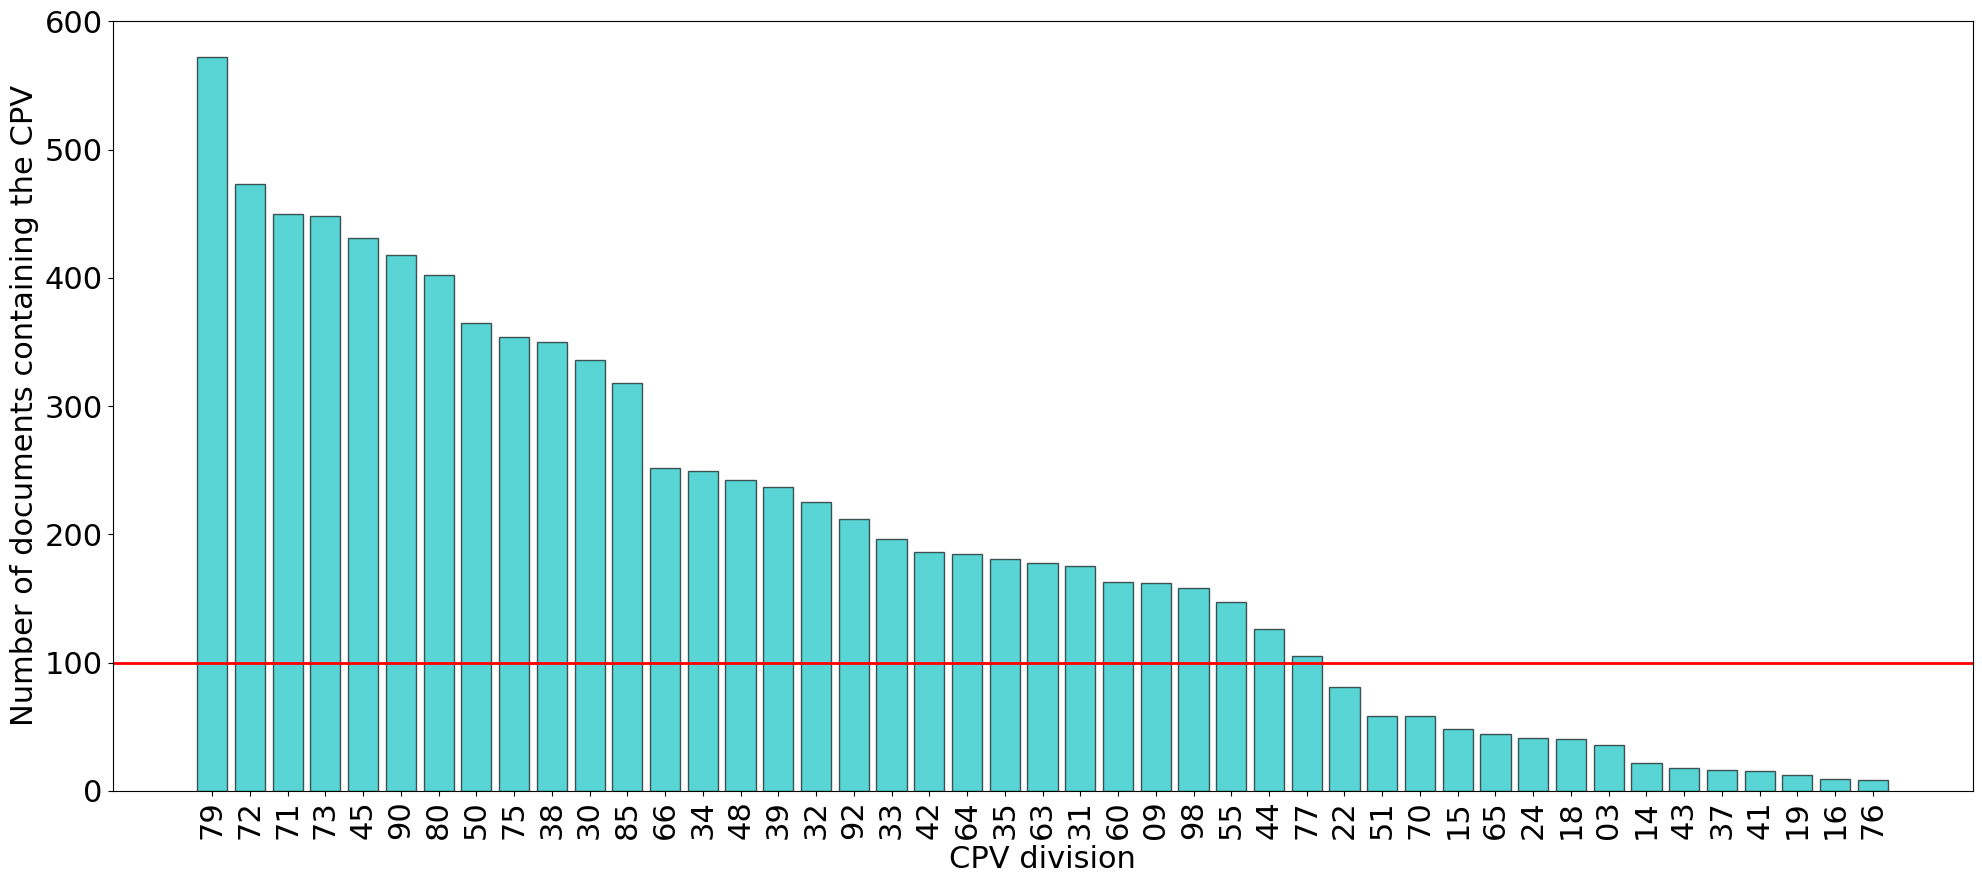

In [27]:
import matplotlib
import matplotlib.pyplot as plt

font = {'size': 22}
matplotlib.rc('font', **font)


def create_barplot_from_dict(dictionary, threshold):
    plt.figure(figsize=(24,10))
    plt.bar(dictionary.keys(), dictionary.values(), color='c', edgecolor='k', alpha=0.65)
    plt.axhline(y=threshold,linewidth=2, color='r')
    plt.xticks(rotation=90)



def count_elements_in_dataframe_from_columns(df, list_column_names):
    found_aggregation = dict()
    for _, row in df.iterrows():
        for column_name in list_column_names:
            if row[column_name]:
                if column_name not in found_aggregation:
                    found_aggregation[column_name] = 1
                else:
                    found_aggregation[column_name] = found_aggregation[column_name] + 1

    return found_aggregation

# Plot divisions vs number of documents containing the division
count_of_cpvs = count_elements_in_dataframe_from_columns(df_undersampled, all_cpvs)
sorted_count_of_cpvs = dict(sorted(count_of_cpvs.items(), key=lambda x:x[1], reverse=True))
create_barplot_from_dict(sorted_count_of_cpvs, 100)
plt.ylabel("Number of documents containing the CPV")
plt.xlabel("CPV division")

In [35]:
df_undersampled.head(1)

title_texte    85     44     50  \
54   provision service relate blood urine test che...  True  False  False   

       80     73     45     71     79     90  ...     18     03     24     43  \
54  False  False  False  False  False  False  ...  False  False  False  False   

       19     41     37     14     16     76  
54  False  False  False  False  False  False  

[1 rows x 46 columns]

In [36]:
df_undersampled.to_csv("undersampled_dataset.csv")

In [37]:
df_undersampled = pd.read_csv('undersampled_dataset.csv', index_col=0)

In [38]:
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier


X = df_undersampled['title_texte']
Y = df_undersampled.drop(['title_texte'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)



SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                ('clf', OneVsRestClassifier(LinearSVC(max_iter=10000, C=20, random_state=736283))),
            ])


SVC_pipeline.fit(X_train, y_train)
print('clf fit done')
y_pred = SVC_pipeline.predict(X_test)

clf fit done


In [39]:
print(metrics.classification_report(y_test, y_pred, target_names=all_cpvs))
print(multi_label_metrics(y_test, y_pred))

              precision    recall  f1-score   support

          85       0.91      0.71      0.80        55
          44       0.67      0.26      0.38        23
          50       0.81      0.72      0.76        90
          80       0.82      0.80      0.81        79
          73       0.64      0.44      0.52        94
          45       0.72      0.64      0.68        75
          71       0.56      0.27      0.36       109
          79       0.70      0.29      0.42       112
          90       0.88      0.65      0.75        88
          30       0.74      0.53      0.62        64
          35       0.69      0.35      0.47        31
          33       0.96      0.54      0.69        41
          55       0.86      0.71      0.77        34
          72       0.65      0.41      0.51        82
          48       0.61      0.35      0.45        48
          38       0.69      0.52      0.60        65
          09       0.89      0.50      0.64        32
          75       0.61    

/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/weickeli/ARHS/Workspace/TedAI/lio-cpvs/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Prediction on procurement data
Dataset available at s3://d-ew1-ted-ai-experiments-data/CPVs/202303/20230301-procurement_data_for_eu_notices.csv

In [74]:
from ast import literal_eval
import pandas as pd
import re
import numpy as np

df_proc = pd.read_csv('procurements_data/20230301-procurement_data_for_eu_notices.csv', dtype={'main_cpv': str}, converters={"additional_cpvs": literal_eval, "procurement_data": literal_eval})
df.tail()

id      notice_type  main_cpv additional_cpvs  \
3818  2020/S 106-255487  Contract notice  34113200              []   
3819  2022/S 125-351443  Contract notice  48461000              []   
3820  2022/S 101-278437  Contract notice  63500000              []   
3821  2018/S 052-114411  Contract notice  79300000              []   
3822  2019/S 118-288646  Contract notice  31682210              []   

                                         etendering_url  \
3818  https://etendering.ted.europa.eu/cft/cft-displ...   
3819  https://etendering.ted.europa.eu/cft/cft-displ...   
3820  https://etendering.ted.europa.eu/cft/cft-displ...   
3821  https://etendering.ted.europa.eu/cft/cft-displ...   
3822  https://etendering.ted.europa.eu/cft/cft-displ...   

                                       procurement_data  
3818  [1 TENDERING SPECIFICATIONS Call for tenders E...  
3819  [ORDER NOEUROPEAN COMMISSION JOINT RESEARCH CE...  
3820  [22ETF02 Tender specifications Regional SEET P...  
3821  [MODEL TERMS OF REFERENCE TENDER SPECIFICATION...  
3822  [index.php NE.45.2301.A.022 ND.45.1001011.A.01...

In [75]:
all_cpvs = ['85', '44', '50', '80', '73', '45', '71', '79', '90', '30', '35', '33', '55', '72', '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51', '32', '65', '77', '22', '63', '15', '70', '18', '03', '24', '43', '19', '41', '37', '14', '16', '76']

In [76]:
#df_proc = df_proc[:1000]
all_results = []
for index, row in df_proc.iterrows():
    
    procurement_data = row["procurement_data"]
    merged_procurement_data = " ".join(procurement_data)
    merged_procurement_data = re.sub('http://\S+|https://\S+', '', merged_procurement_data)
    splitted_by_dot = list(filter(None, merged_procurement_data.split(".")))
    result_row = []
    for element in splitted_by_dot:

        if len(element) < 100 or len(element) > 510:
            continue
        
        text_input = unidecode(element.lower())
        text_input = _remove_special_characters(text_input)
        text_input = _replace_with_lemma(text_input)
        text_input = _remove_stop_words(text_input)
        text_input = _remove_multiple_spaces(text_input)
        text_input = _replace_digits(text_input)
        text_input = _delete_one_letter_word(text_input)
        text_input = _remove_consecutive_duplicates(text_input)
        text_input = _replace_months(text_input)
        result = SVC_pipeline.predict([text_input])
        results_as_division = [all_cpvs[ind] for ind, element in enumerate(result[0]) if element]
        if results_as_division:
            for lab in results_as_division:
                result_row.append(lab)

    all_results.append(set(result_row))

In [77]:
print(all_results)

[{'72', '85', '73', '45', '66'}, {'79', '80'}, {'30', '72', '63', '79', '50', '80', '73', '45', '90', '66'}, {'60', '64', '79', '73', '45', '66'}, {'71', '31', '72', '79', '73', '80', '48', '42', '38', '45', '90', '35'}, {'79', '73', '80', '45', '90', '66'}, {'72', '79', '73', '80', '48', '45', '90', '66'}, {'90', '66', '79', '55'}, {'72', '63', '79', '80', '48', '45', '90', '66'}, {'64', '72', '79', '73', '90', '66'}, {'79', '66'}, {'63', '79', '73', '80', '45', '90', '66'}, {'30', '72', '63', '79', '80', '73', '45', '66'}, {'50', '38'}, {'45', '38', '42'}, {'63', '79', '80', '73', '45', '90', '66'}, {'90', '30', '48'}, {'79'}, {'32', '72', '79', '80', '73', '48', '45', '66'}, {'73', '80', '55', '45', '66'}, {'79', '73', '80', '55', '66'}, {'30', '72', '79', '33', '73', '80', '34', '15', '45', '90', '66', '98'}, {'64', '72', '79', '73', '80', '90', '66'}, {'72', '63', '79', '73', '34', '45'}, {'72', '79', '73', '45', '90', '66'}, {'71', '72', '79', '50', '90', '09'}, {'71', '72', '63'

In [78]:
import copy
df_copied = copy.deepcopy(df_proc)

In [79]:
df_copied["predicted"] = all_results
df_copied.head()

id      notice_type  main_cpv additional_cpvs  \
0  2017/S 102-203726  Contract notice  85100000              []   
1  2014/S 138-246767  Contract notice  80580000              []   
2  2017/S 164-337354  Contract notice  80600000              []   
3  2016/S 070-121405  Contract notice  73000000              []   
4  2022/S 084-222910  Contract notice  71000000              []   

                                      etendering_url  \
0  https://etendering.ted.europa.eu/cft/cft-displ...   
1  https://etendering.ted.europa.eu/cft/cft-displ...   
2  https://etendering.ted.europa.eu/cft/cft-displ...   
3  https://etendering.ted.europa.eu/cft/cft-displ...   
4  https://etendering.ted.europa.eu/cft/cft-displ...   

                                    procurement_data  \
0  [Tender Specificationsopen callreview july 201...   
1  [Annex12013POEJ4.DOCX ANNEX 1 2014/PO/EJ/10 Pa...   
2  [4102cahierdeschargesopenprocedureenjuly2010.d...   
3  [4102cahierdeschargesopenprocedureenjuly2010.d...   
4  [European Commission DG Joint Research Centre ...   

                                          predicted  
0                              {72, 85, 73, 45, 66}  
1                                          {79, 80}  
2          {30, 72, 63, 79, 50, 80, 73, 45, 90, 66}  
3                          {60, 64, 79, 73, 45, 66}  
4  {71, 31, 72, 79, 73, 80, 48, 42, 38, 45, 90, 35}

In [80]:
df_copied = df_copied.drop(['notice_type', 'etendering_url', 'procurement_data'], axis = 1)
df_copied.to_csv("undersampling_linearsvc_model_procurement_data_actual_vs_predicted.csv")

In [81]:
df_copied.to_csv("undersampling_linearsvc_model_procurement_data_actual_vs_predicted.csv")

In [82]:
import pandas as pd
from ast import literal_eval

df_copied = pd.read_csv("undersampling_linearsvc_model_procurement_data_actual_vs_predicted.csv", dtype={'main_cpv': str}, converters={"additional_cpvs": literal_eval}, index_col=0)

In [83]:
for index, row in df_copied.iterrows():
    row_value = row["predicted"]
    row_value = row_value.replace("{", "")
    row_value = row_value.replace("}", "")
    row_value = row_value.replace("'", "")
    row_value = row_value.replace("set()", "")
    row_value = row_value.split(",")
    new_result = [x.strip() for x in row_value]
    row["predicted"] = new_result



In [84]:
df_copied.head()

id  main_cpv additional_cpvs  \
0  2017/S 102-203726  85100000              []   
1  2014/S 138-246767  80580000              []   
2  2017/S 164-337354  80600000              []   
3  2016/S 070-121405  73000000              []   
4  2022/S 084-222910  71000000              []   

                                          predicted  
0                              [72, 85, 73, 45, 66]  
1                                          [79, 80]  
2          [30, 72, 63, 79, 50, 80, 73, 45, 90, 66]  
3                          [60, 64, 79, 73, 45, 66]  
4  [71, 31, 72, 79, 73, 80, 48, 42, 38, 45, 90, 35]

In [85]:
df_copied['main_cpv'] = df_copied['main_cpv'].apply(lambda x: x[:2])
# Merge additional_cpvs and main_cpv into all_cpvs
#all_cpvs = []
df_copied["all_cpvs"] = ""

for ind, row in df_copied.iterrows():
  main_cpv = row['main_cpv']
  additionnal_cpvs = row['additional_cpvs']
  cpvs_rows = []
  if main_cpv:
    cpvs_rows.append(main_cpv)
  if additionnal_cpvs:
    cpvs_rows.extend(row['additional_cpvs'])

  cpv_to_add = []

  for cpv in cpvs_rows:
    if cpv:
      division_cpv = cpv[:2]
      if division_cpv not in cpv_to_add:
        cpv_to_add.append(division_cpv)
      #if division_cpv not in all_cpvs:
      #  all_cpvs.append(division_cpv)
  row["all_cpvs"] = cpv_to_add

df_copied.head(5)

id main_cpv additional_cpvs  \
0  2017/S 102-203726       85              []   
1  2014/S 138-246767       80              []   
2  2017/S 164-337354       80              []   
3  2016/S 070-121405       73              []   
4  2022/S 084-222910       71              []   

                                          predicted all_cpvs  
0                              [72, 85, 73, 45, 66]     [85]  
1                                          [79, 80]     [80]  
2          [30, 72, 63, 79, 50, 80, 73, 45, 90, 66]     [80]  
3                          [60, 64, 79, 73, 45, 66]     [73]  
4  [71, 31, 72, 79, 73, 80, 48, 42, 38, 45, 90, 35]     [71]

In [86]:
proportion_division_in_prediction = []
for ind, row in df_copied.iterrows():
    local_result = 0
    number_cpvs = len(row["all_cpvs"])
    for individual_cpv in row["all_cpvs"]:
        if individual_cpv in row["predicted"]:
            local_result += 1
    
    proportion_division_in_prediction.append(local_result/number_cpvs)

df_copied["prop_div_in_pred"] = proportion_division_in_prediction
df_copied.head()

id main_cpv additional_cpvs  \
0  2017/S 102-203726       85              []   
1  2014/S 138-246767       80              []   
2  2017/S 164-337354       80              []   
3  2016/S 070-121405       73              []   
4  2022/S 084-222910       71              []   

                                          predicted all_cpvs  prop_div_in_pred  
0                              [72, 85, 73, 45, 66]     [85]               1.0  
1                                          [79, 80]     [80]               1.0  
2          [30, 72, 63, 79, 50, 80, 73, 45, 90, 66]     [80]               1.0  
3                          [60, 64, 79, 73, 45, 66]     [73]               1.0  
4  [71, 31, 72, 79, 73, 80, 48, 42, 38, 45, 90, 35]     [71]               1.0

{0.0: 261, 0.3333333333333333: 1, 0.4: 1, 0.5: 4, 1.0: 3556}


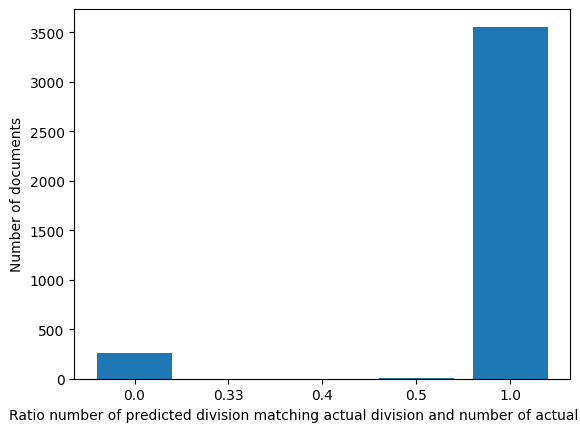

In [87]:
import matplotlib
import matplotlib.pyplot as plt

value_count = dict(df_copied['prop_div_in_pred'].value_counts())
ordered_keys_value_count = dict(sorted(value_count.items()))
print(ordered_keys_value_count)
font = {'size': 10}
matplotlib.rc('font', **font)

x_axis = list(ordered_keys_value_count.keys())
x_axis = [round(x, 2) for x in x_axis]
plt.bar(range(len(ordered_keys_value_count)), ordered_keys_value_count.values(), tick_label=x_axis)
plt.ylabel("Number of documents")
plt.xlabel("Ratio number of predicted division matching actual division and number of actual division")
plt.show()


In [88]:
number_of_wrong_division = []
for ind, row in df_copied.iterrows():
    local_result = 0
    for individual_cpv in row["predicted"]:
        if individual_cpv not in row["all_cpvs"]:
            local_result += 1
    
    number_of_wrong_division.append(local_result)
    
df_copied["number_wrong_predicted_division"] = number_of_wrong_division
df_copied.head()


id main_cpv additional_cpvs  \
0  2017/S 102-203726       85              []   
1  2014/S 138-246767       80              []   
2  2017/S 164-337354       80              []   
3  2016/S 070-121405       73              []   
4  2022/S 084-222910       71              []   

                                          predicted all_cpvs  \
0                              [72, 85, 73, 45, 66]     [85]   
1                                          [79, 80]     [80]   
2          [30, 72, 63, 79, 50, 80, 73, 45, 90, 66]     [80]   
3                          [60, 64, 79, 73, 45, 66]     [73]   
4  [71, 31, 72, 79, 73, 80, 48, 42, 38, 45, 90, 35]     [71]   

   prop_div_in_pred  number_wrong_predicted_division  
0               1.0                                4  
1               1.0                                1  
2               1.0                                9  
3               1.0                                5  
4               1.0                               11

{0: 27, 1: 151, 2: 162, 3: 286, 4: 369, 5: 540, 6: 628, 7: 515, 8: 377, 9: 281, 10: 194, 11: 106, 12: 72, 13: 37, 14: 13, 15: 13, 16: 16, 17: 11, 18: 11, 19: 2, 20: 3, 21: 3, 22: 2, 23: 1, 24: 2, 25: 1}


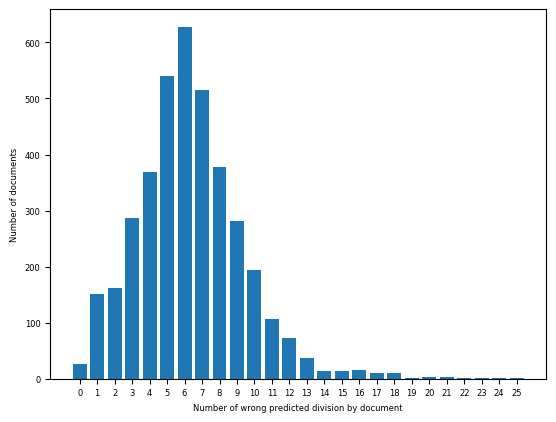

In [89]:
value_count = dict(df_copied['number_wrong_predicted_division'].value_counts())
ordered_keys_value_count = dict(sorted(value_count.items()))
print(ordered_keys_value_count)
font = {'size': 6}
matplotlib.rc('font', **font)

x_axis = list(ordered_keys_value_count.keys())
x_axis = [round(x, 2) for x in x_axis]
plt.bar(range(len(ordered_keys_value_count)), ordered_keys_value_count.values(), tick_label=x_axis)
plt.ylabel("Number of documents")
plt.xlabel("Number of wrong predicted division by document")
plt.show()

In [90]:
wrong_divisions = []
for ind, row in df_copied.iterrows():
    local_result = []
    for individual_cpv in row["predicted"]:
        if individual_cpv not in row["all_cpvs"]:
            local_result.append(individual_cpv)
    
    wrong_divisions.append(local_result)
    
df_copied["wrong_divisions"] = wrong_divisions
df_copied.head()


id main_cpv additional_cpvs  \
0  2017/S 102-203726       85              []   
1  2014/S 138-246767       80              []   
2  2017/S 164-337354       80              []   
3  2016/S 070-121405       73              []   
4  2022/S 084-222910       71              []   

                                          predicted all_cpvs  \
0                              [72, 85, 73, 45, 66]     [85]   
1                                          [79, 80]     [80]   
2          [30, 72, 63, 79, 50, 80, 73, 45, 90, 66]     [80]   
3                          [60, 64, 79, 73, 45, 66]     [73]   
4  [71, 31, 72, 79, 73, 80, 48, 42, 38, 45, 90, 35]     [71]   

   prop_div_in_pred  number_wrong_predicted_division  \
0               1.0                                4   
1               1.0                                1   
2               1.0                                9   
3               1.0                                5   
4               1.0                               11   

                                wrong_divisions  
0                              [72, 73, 45, 66]  
1                                          [79]  
2          [30, 72, 63, 79, 50, 73, 45, 90, 66]  
3                          [60, 64, 79, 45, 66]  
4  [31, 72, 79, 73, 80, 48, 42, 38, 45, 90, 35]

In [91]:
import matplotlib
import matplotlib.pyplot as plt

font = {'size': 22}
matplotlib.rc('font', **font)


def create_barplot_from_dict(dictionary, threshold):
    plt.figure(figsize=(24,10))
    plt.bar(dictionary.keys(), dictionary.values(), color='b', edgecolor='k', alpha=0.65)
    if threshold:
        plt.axhline(y=threshold,linewidth=2, color='r')
    plt.xticks(rotation=90)



def count_elements_in_dataframe_from_columns(df, list_column_names):
    found_aggregation = dict()
    for _, row in df.iterrows():
        for column_name in list_column_names:
            if row[column_name]:
                if column_name not in found_aggregation:
                    found_aggregation[column_name] = 1
                else:
                    found_aggregation[column_name] = found_aggregation[column_name] + 1

    return found_aggregation

In [92]:
number_wrong_division_prediction = {}
for ind, row in df_copied.iterrows():
    for individual_cpv in row["wrong_divisions"]:
        if individual_cpv not in number_wrong_division_prediction.keys():
            number_wrong_division_prediction[individual_cpv] = 1
        else:
            number_wrong_division_prediction[individual_cpv] += 1

print(number_wrong_division_prediction)

{'72': 1667, '73': 1934, '45': 2196, '66': 2887, '79': 2018, '30': 794, '63': 1102, '50': 538, '90': 2221, '60': 224, '64': 460, '31': 202, '80': 2429, '48': 983, '42': 119, '38': 331, '35': 294, '32': 365, '55': 494, '33': 135, '34': 376, '15': 24, '98': 50, '09': 186, '71': 568, '14': 43, '77': 72, '75': 254, '85': 395, '39': 229, '92': 249, '44': 49, '22': 149, '24': 44, '65': 10, '51': 2, '03': 12, '': 29, '18': 40, '70': 19, '43': 2, '76': 1, '37': 1}


Text(0.5, 0, 'CPV division')

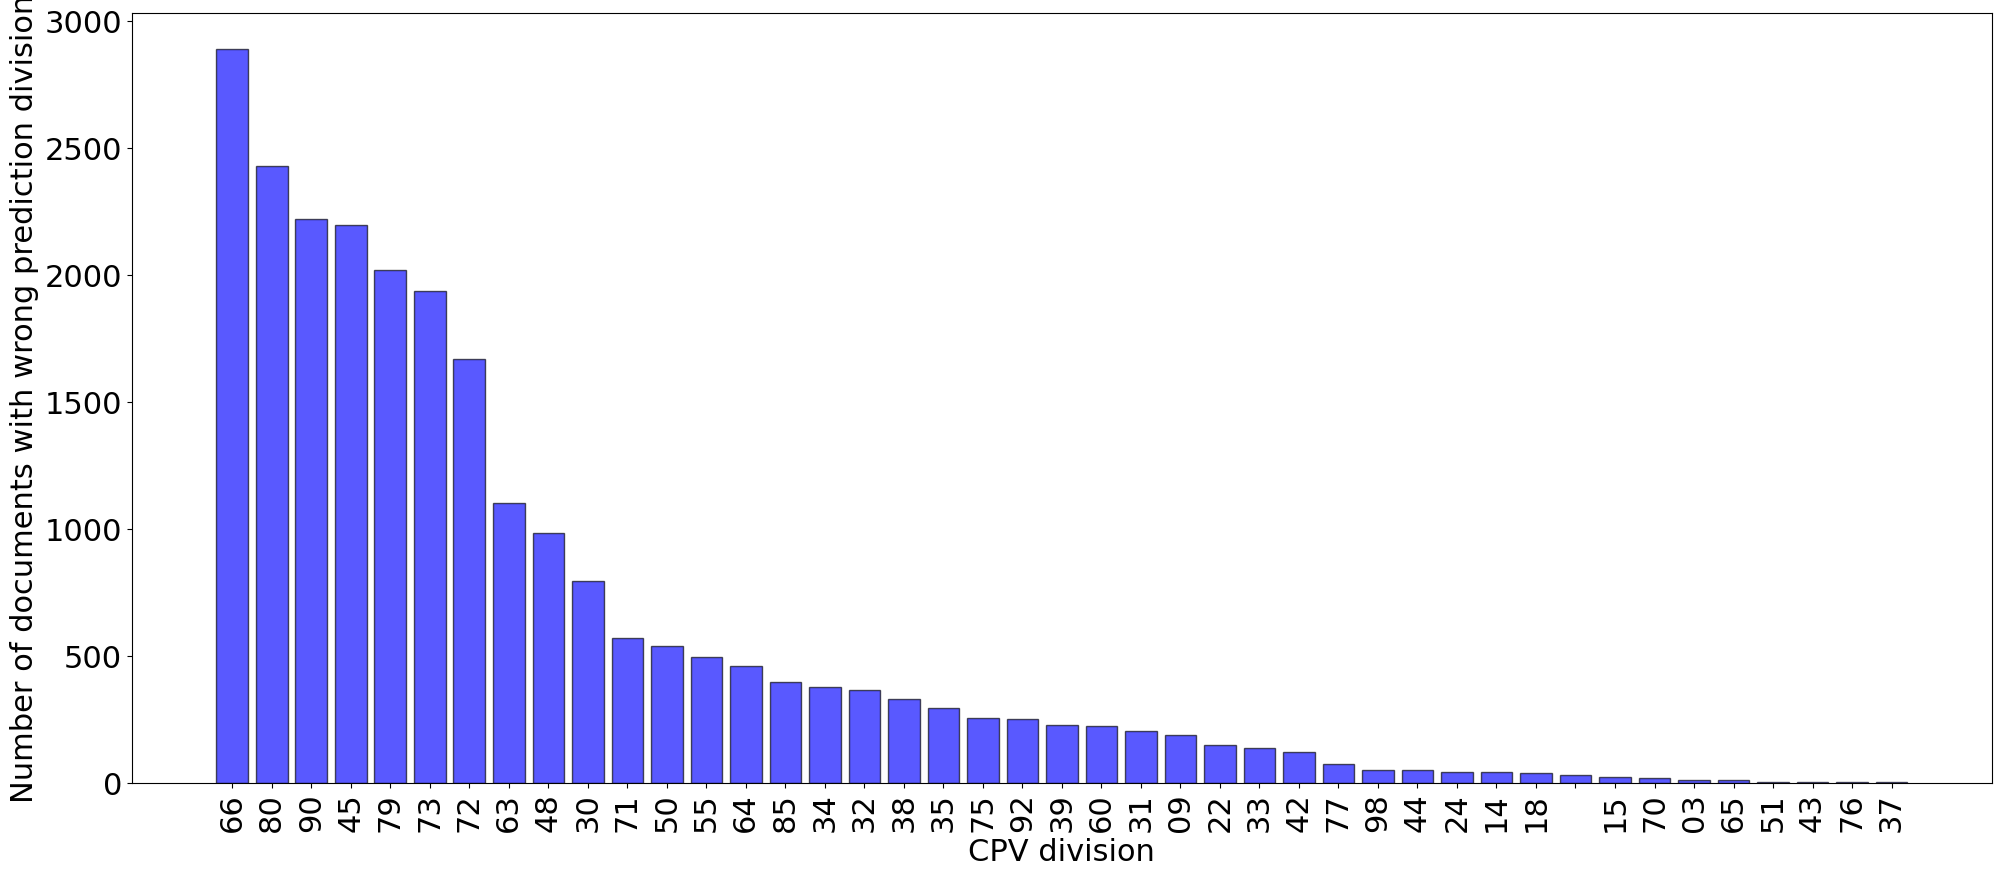

In [93]:
sorted_count_of_cpvs = dict(sorted(number_wrong_division_prediction.items(), key=lambda x:x[1], reverse=True))
create_barplot_from_dict(sorted_count_of_cpvs, None)
plt.ylabel("Number of documents with wrong prediction division")
plt.xlabel("CPV division")

In [94]:
sorted_count_of_cpvs

{'66': 2887,
 '80': 2429,
 '90': 2221,
 '45': 2196,
 '79': 2018,
 '73': 1934,
 '72': 1667,
 '63': 1102,
 '48': 983,
 '30': 794,
 '71': 568,
 '50': 538,
 '55': 494,
 '64': 460,
 '85': 395,
 '34': 376,
 '32': 365,
 '38': 331,
 '35': 294,
 '75': 254,
 '92': 249,
 '39': 229,
 '60': 224,
 '31': 202,
 '09': 186,
 '22': 149,
 '33': 135,
 '42': 119,
 '77': 72,
 '98': 50,
 '44': 49,
 '24': 44,
 '14': 43,
 '18': 40,
 '': 29,
 '15': 24,
 '70': 19,
 '03': 12,
 '65': 10,
 '51': 2,
 '43': 2,
 '76': 1,
 '37': 1}

In [95]:
total_wrong = 0
for key, value in sorted_count_of_cpvs.items():
    total_wrong += value

print(f"Total wrong predictions: {total_wrong}")

Total wrong predictions: 24197


Comparison between results from roberta and linearsvc models

In [96]:
roberta_results = {'71': 3537,
 '72': 2911,
 '66': 2883,
 '75': 2773,
 '79': 2652,
 '73': 2426,
 '80': 2208,
 '90': 2048,
 '63': 1493,
 '48': 1319,
 '30': 1181,
 '45': 1074,
 '60': 739,
 '55': 656,
 '32': 642,
 '64': 541,
 '34': 525,
 '50': 518,
 '39': 424,
 '85': 390,
 '35': 374,
 '38': 298,
 '92': 252,
 '33': 250,
 '42': 222,
 '31': 188,
 '22': 170,
 '77': 151,
 '09': 150,
 '70': 82,
 '44': 55,
 '15': 24,
 '18': 24,
 '': 13,
 '98': 9}

linera_svc_results = {'79': 2622,
 '73': 2544,
 '71': 2349,
 '45': 2344,
 '72': 2137,
 '90': 2049,
 '80': 1593,
 '66': 1361,
 '63': 950,
 '30': 689,
 '48': 682,
 '50': 440,
 '64': 425,
 '32': 339,
 '55': 319,
 '34': 295,
 '85': 291,
 '38': 253,
 '39': 194,
 '60': 126,
 '35': 119,
 '31': 118,
 '09': 111,
 '92': 109,
 '42': 104,
 '33': 74,
 '22': 62,
 '75': 39,
 '15': 37,
 '18': 34,
 '98': 31,
 '44': 27,
 '77': 26,
 '14': 25,
 '24': 24,
 '03': 21,
 '': 21,
 '70': 10,
 '65': 3,
 '43': 2,
 '41': 1,
 '51': 1,
 '76': 1}
linera_svc_undersampled_results = {'66': 2887,
 '80': 2429,
 '90': 2221,
 '45': 2196,
 '79': 2018,
 '73': 1934,
 '72': 1667,
 '63': 1102,
 '48': 983,
 '30': 794,
 '71': 568,
 '50': 538,
 '55': 494,
 '64': 460,
 '85': 395,
 '34': 376,
 '32': 365,
 '38': 331,
 '35': 294,
 '75': 254,
 '92': 249,
 '39': 229,
 '60': 224,
 '31': 202,
 '09': 186,
 '22': 149,
 '33': 135,
 '42': 119,
 '77': 72,
 '98': 50,
 '44': 49,
 '24': 44,
 '14': 43,
 '18': 40,
 '': 29,
 '15': 24,
 '70': 19,
 '03': 12,
 '65': 10,
 '51': 2,
 '43': 2,
 '76': 1,
 '37': 1}

In [101]:
all_divisions = ['85', '44', '50', '80', '73', '45', '71', '79', '90', '30', '35', '33', '55', '72', '48', '38', '09', '75', '66', '64', '42', '34', '60', '92', '39', '31', '98', '51', '32', '65', '77', '22', '63', '15', '70', '18', '03', '24', '43', '19', '41', '37', '14', '16', '76', '']

In [102]:
ordered_roberta_wrong_divisions = {}
for element in all_divisions:
    if element in list(roberta_results.keys()):
        ordered_roberta_wrong_divisions[element] = roberta_results[element]
    else:
        ordered_roberta_wrong_divisions[element] = 0

In [103]:
ordered_linear_svc_wrong_divisions = {}
for element in all_divisions:
    if element in list(linera_svc_results.keys()):
        ordered_linear_svc_wrong_divisions[element] = linera_svc_results[element]
    else:
        ordered_linear_svc_wrong_divisions[element] = 0

In [104]:
ordered_linear_svc_undersampled_wrong_divisions = {}
for element in all_divisions:
    if element in list(linera_svc_undersampled_results.keys()):
        ordered_linear_svc_undersampled_wrong_divisions[element] = linera_svc_undersampled_results[element]
    else:
        ordered_linear_svc_undersampled_wrong_divisions[element] = 0

In [105]:
min_total_wrong_by_mix = 0

for element in all_divisions:
    val_roberta = ordered_roberta_wrong_divisions[element]
    val_linear = ordered_linear_svc_wrong_divisions[element]
    val_linear_undersampled = ordered_linear_svc_undersampled_wrong_divisions[element]
    list_val = [val_linear, val_linear_undersampled, val_roberta]
    list_val.sort()
    min_total_wrong_by_mix += list_val[0]


print(f"Number of wrong predictions by mixing models: {min_total_wrong_by_mix}")

Number of wrong predictions by mixing models: 18135


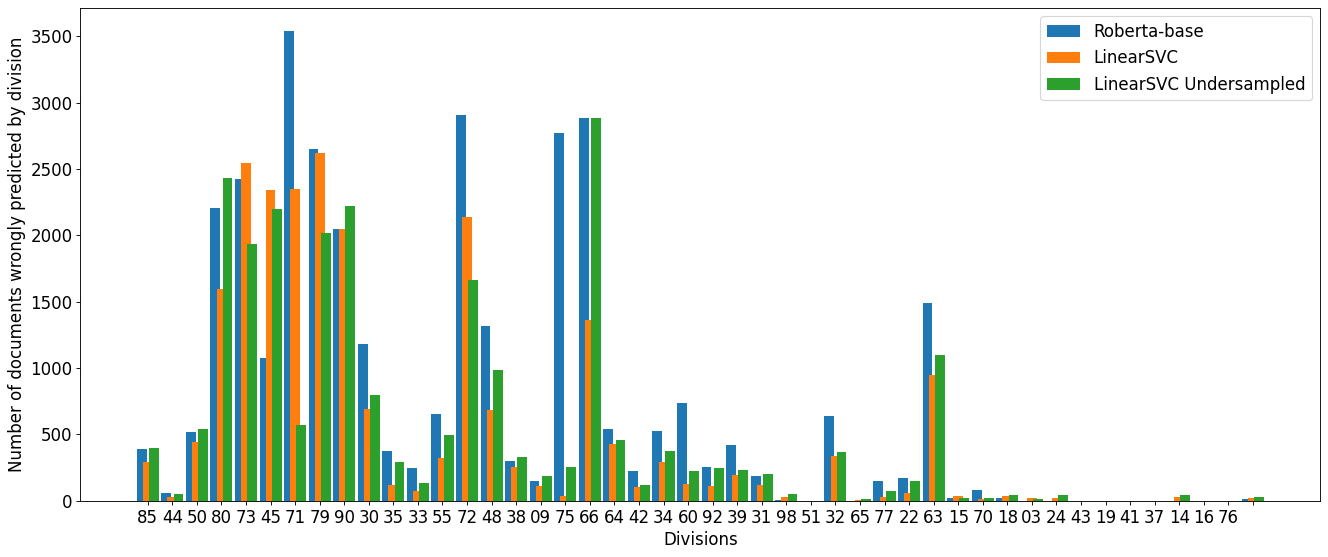

In [109]:
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

figure(figsize=(20, 8), dpi=80)
font = {'size': 15}
matplotlib.rc('font', **font)

X = list(ordered_linear_svc_wrong_divisions.keys())
values_roberta = list(ordered_roberta_wrong_divisions.values())
values_linear_svc = list(ordered_linear_svc_wrong_divisions.values())
values_linear_svc_undersampled = list(ordered_linear_svc_undersampled_wrong_divisions.values())

  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.25, values_roberta, 0.4, label = 'Roberta-base')
plt.bar(X_axis, values_linear_svc, 0.4, label = 'LinearSVC')
plt.bar(X_axis + 0.25, values_linear_svc_undersampled, 0.4, label = 'LinearSVC Undersampled')

  
plt.xticks(X_axis, X)
plt.xlabel("Divisions")
plt.ylabel("Number of documents wrongly predicted by division")
plt.legend()
plt.show()